In [102]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import plotly.express as px

import math
from icp import icp

import copy
import pylab
import time
import sys
import sklearn.neighbors
import scipy.optimize
import random

# Méthode "Iterative Closest Point"

## 1.Problème:

Dans le nuage des points obtenu par lidar, on peut obtenir des clusters par DBSCANS. Notre objective est de trouver les clusters qui rassemblent à notre balise.

### Première approche

En premier temps, nous allons appliquer le méthode d'ICP. Le principe de cette méthode est de calculer la transformation optimale (composée d'une rotation et d'une translation) minimisant un critère de distance entre 2 nuage de points. Nous avons construit un dataset de balises en différent distance (). Nous allons l'utiliser comme le standard pour comparer. 

### Modélisation le problème

Soit $M_k$ notre kième cluster. Selon la distance de ce cluster, on choisi le standard S pour comparer.
Notre problème s'écrit:

$ min_{T \in \mathcal{T}} || T(M_k)-S|| $

où $\mathcal{T}$ est l'ensemble des transformation composée d'une rotation et d'une translation


In [103]:
#Notre nuage de point: 
# Loading dataset
df = pd.read_csv('Data/data.csv')
pd.options.display.max_rows = 100
NB_SAMPLES = 20

# Error corecction
x = df['x']
df['x'] = df['angle']
df['angle'] = x

y = df['y']
df['y'] = df['dist']
df['dist'] = y

df=df[:][:583]
# Dbscan Clustering
clustering = DBSCAN(eps=50, min_samples=3).fit_predict(df[['x','y']])

# angle / distance

df['clus']=clustering

nb_clus=len(np.unique(clustering))
clus=[]
for i in np.unique(clustering):
    clus.append(df[df['clus']==i][['x','y']])

In [104]:
clus[0].to_numpy().T

array([[-2035.71908904, -2042.32068634, -2691.51292538, -2779.2006091 ,
        -4397.59026042, -3512.26091496, -3460.55138801, -3417.72613914,
        -2021.68575201, -2097.42358262, -1360.67642352, -1337.63202827,
         -917.0708065 ,  -627.25155769,  -836.31417705,   285.31689671,
          708.83953719],
       [ -932.18495509,  -920.06859208,  -534.12935935,  -533.80143723,
          111.3593347 ,   110.54078555,   130.20403572,   149.62966889,
         1232.96825593,  1296.90798251,  1866.72431561,  1883.30575238,
         1360.83141347,  1525.04310869,  2069.3966747 ,   367.17743456,
          215.93404205]])

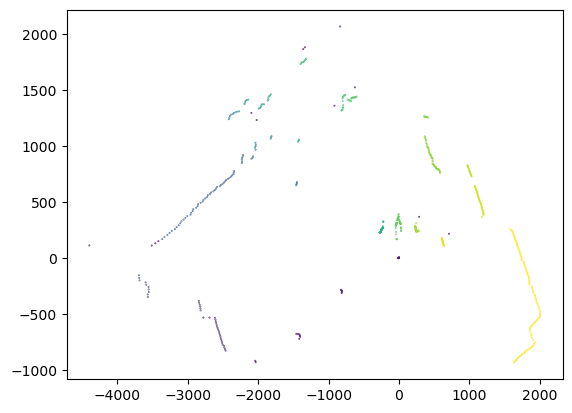

In [105]:
plt.scatter(df['x'],df['y'],c = clustering, marker='.', s=.5)
plt.show()

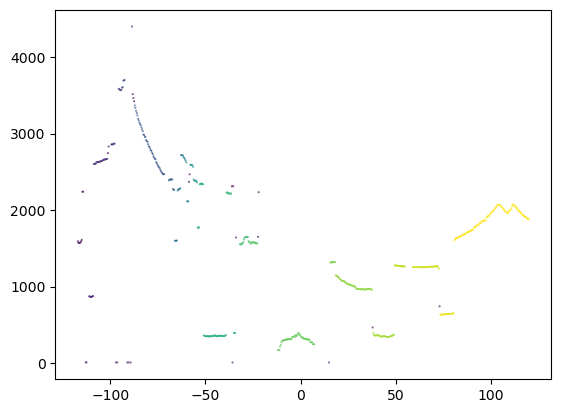

In [106]:
plt.scatter(df['angle'],df['dist'],c = clustering, marker='.', s=.5)
plt.show()

In [107]:
nb_clus

31

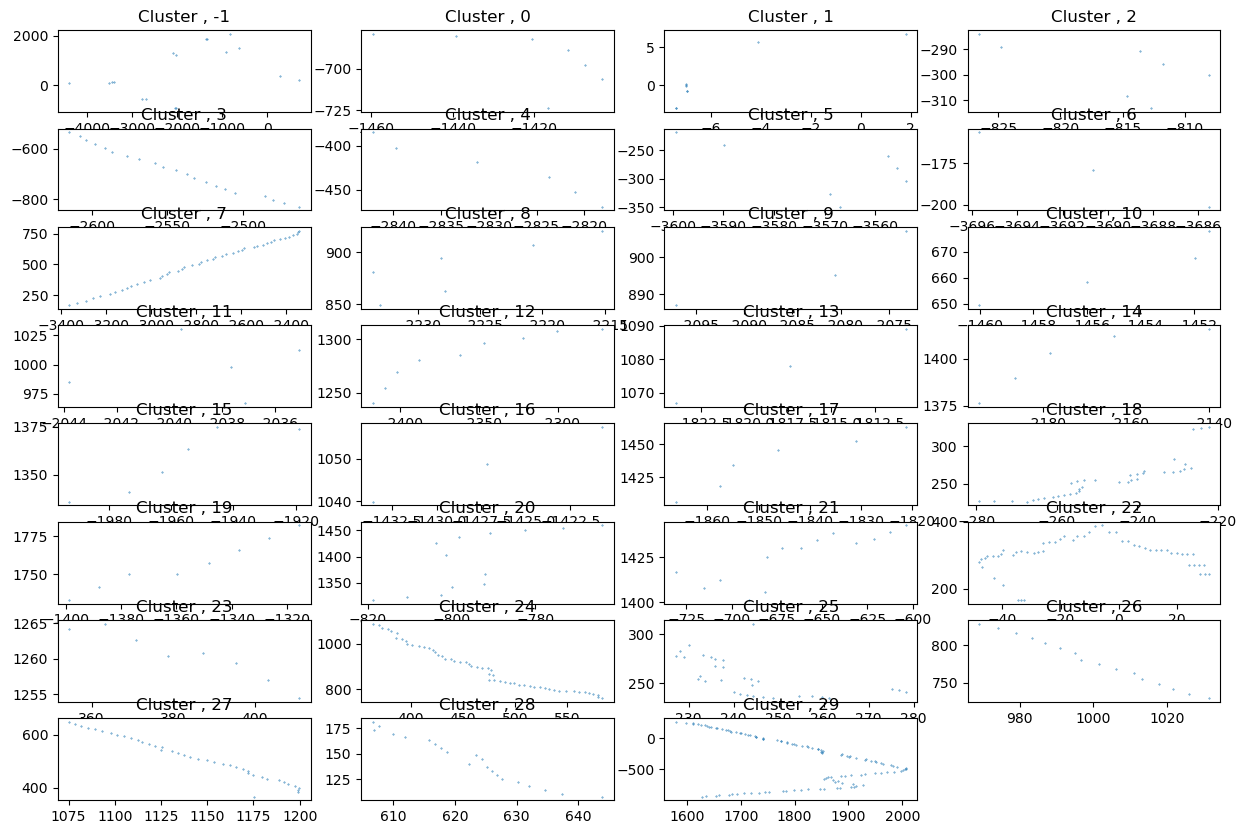

In [108]:
fig = plt.figure(figsize = (15,10))
for i in range(nb_clus):
    plt.subplot(int(nb_clus/4)+1,4,i+1)
    plt.scatter(clus[i]['x'],clus[i]['y'], marker='.', s=.5)
    plt.title("Cluster , {cl}".format(cl=i-1))
    

## 2. Algorithm ICP

Notre transformation s'écrit:

$\binom{x'}{y'}=\binom{cos \theta \ \ \ -sin \theta}{sin \theta \ \ \ cos \theta} \binom{x}{y} + \binom{a}{b} $

(x',y') point dans le nuage standard, (x,y) point dans le cluster

Algo:

+ Step 0: Considérons le k-ieme cluster en le diamètre d par le centre est notre lidar (notre robot). On va le comparer avec le standard $S_d$

+ Step 1: Algorithm ICP

Soient $u_i=(x_i',y_i') $ et $v_i=(x_i,y_i) $ ième point dans le standard et le nuage pour $i=1,...,N$ (N:nombre de points dans le nuage) ,

Notre problème à minimiser

$\sum_{i=1}^N ||T(v_i)-u_i||²$


In [109]:
def transformation(theta,a,b,nuage):
    #nuage: 
    W=np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])
    d=W.dot(nuage)
    return d

In [147]:
#Code from Kaggel
#link https://www.kaggle.com/code/demetrypascal2/icp-algorithm-test/notebook

def icp(a, b,
        max_time = 15
    ):


    def res(p,src,dst):
        T = np.matrix([[np.cos(p[2]),-np.sin(p[2]),p[0]],
        [np.sin(p[2]), np.cos(p[2]),p[1]],
        [0 ,0 ,1 ]])
        n = np.size(src,0)
        xt = np.ones([n,3])
        xt[:,:-1] = src
        xt = (xt*T.T).A
        d = np.zeros(np.shape(src))
        d[:,0] = xt[:,0]-dst[:,0]
        d[:,1] = xt[:,1]-dst[:,1]
        r = np.sum(np.square(d[:,0])+np.square(d[:,1]))
        return r

    def jac(p,src,dst):
        T = np.matrix([[np.cos(p[2]),-np.sin(p[2]),p[0]],
        [np.sin(p[2]), np.cos(p[2]),p[1]],
        [0 ,0 ,1 ]])
        n = np.size(src,0)
        xt = np.ones([n,3])
        xt[:,:-1] = src
        xt = (xt*T.T).A
        d = np.zeros(np.shape(src))
        d[:,0] = xt[:,0]-dst[:,0]
        d[:,1] = xt[:,1]-dst[:,1]
        dUdth_R = np.matrix([[-np.sin(p[2]),-np.cos(p[2])],
                            [ np.cos(p[2]),-np.sin(p[2])]])
        dUdth = (src*dUdth_R.T).A
        g = np.array([  np.sum(2*d[:,0]),
                        np.sum(2*d[:,1]),
                        np.sum(2*(d[:,0]*dUdth[:,0]+d[:,1]*dUdth[:,1])) ])
        return g
    
    def hess(p,src,dst):
        n = np.size(src,0)
        T = np.matrix([[np.cos(p[2]),-np.sin(p[2]),p[0]],
        [np.sin(p[2]), np.cos(p[2]),p[1]],
        [0 ,0 ,1 ]])
        n = np.size(src,0)
        xt = np.ones([n,3])
        xt[:,:-1] = src
        xt = (xt*T.T).A
        d = np.zeros(np.shape(src))
        d[:,0] = xt[:,0]-dst[:,0]
        d[:,1] = xt[:,1]-dst[:,1]
        dUdth_R = np.matrix([[-np.sin(p[2]),-np.cos(p[2])],[np.cos(p[2]),-np.sin(p[2])]])
        dUdth = (src*dUdth_R.T).A
        H = np.zeros([3,3])
        H[0,0] = n*2
        H[0,2] = np.sum(2*dUdth[:,0])
        H[1,1] = n*2
        H[1,2] = np.sum(2*dUdth[:,1])
        H[2,0] = H[0,2]
        H[2,1] = H[1,2]
        d2Ud2th_R = np.matrix([[-np.cos(p[2]), np.sin(p[2])],[-np.sin(p[2]),-np.cos(p[2])]])
        d2Ud2th = (src*d2Ud2th_R.T).A
        H[2,2] = np.sum(2*(np.square(dUdth[:,0])+np.square(dUdth[:,1]) + d[:,0]*d2Ud2th[:,0]+d[:,0]*d2Ud2th[:,0]))
        return H
    
    t0 = time.time()
    init_pose = (0,0,0)
    src = np.array([a.T], copy=True).astype(np.float32)
    dst = np.array([b.T], copy=True).astype(np.float32)
    Tr = np.array([[np.cos(init_pose[2]),-np.sin(init_pose[2]),init_pose[0]],
                   [np.sin(init_pose[2]), np.cos(init_pose[2]),init_pose[1]],
                   [0,                    0,                   1          ]])
    print("src",np.shape(src))
    print("Tr[0:2]",np.shape(Tr[0:2]))
    src = cv.transform(src, Tr[0:2])
    p_opt = np.array(init_pose)
    T_opt = np.array([])
    error_max = sys.maxsize
    first = False
    while not(first and time.time() - t0 > max_time):
        distances, indices = sklearn.neighbors.NearestNeighbors(n_neighbors=1, algorithm='auto',p = 3).fit(dst[0]).kneighbors(src[0])
        p = scipy.optimize.minimize(res,[0,0,0],args=(src[0],dst[0, indices.T][0]),method='Newton-CG',jac=jac,hess=hess).x
        T  = np.array([[np.cos(p[2]),-np.sin(p[2]),p[0]],[np.sin(p[2]), np.cos(p[2]),p[1]]])
        p_opt[:2]  = (p_opt[:2]*np.matrix(T[:2,:2]).T).A       
        p_opt[0] += p[0]
        p_opt[1] += p[1]
        p_opt[2] += p[2]
        src = cv.transform(src, T)
        Tr = (np.matrix(np.vstack((T,[0,0,1])))*np.matrix(Tr)).A
        error = res([0,0,0],src[0],dst[0, indices.T][0])

        if error < error_max:
            error_max = error
            first = True
            T_opt = Tr

    p_opt[2] = p_opt[2] % (2*np.pi)
    
    return T_opt, error_max

## 3. Tester le méthode avec les fausses données 

### Test 1

src (1, 8, 2)
Tr[0:2] (2, 3)
T [[ 0.73154865 -0.68178924 -0.49913625]
 [ 0.68178924  0.73154865 -2.58871324]
 [ 0.          0.          1.        ]]
error 0.03308081011043132
rotation° -42.98361960438488
dx -0.4991362457760038
dy -2.5887132413434357


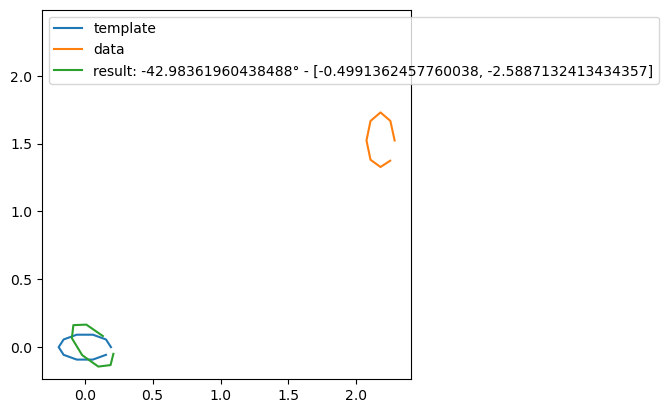

In [150]:
np.random.seed(0)
n1 = 10
n2 = 8
bruit = 1/10
center = [random.random()*(2-1)*3,random.random()*(2-1)*3]
radius = random.random()
deformation = 2

template1 = np.array([
        [np.cos(i*2*np.pi/n1)*radius*deformation for i in range(n1)], 
        [np.sin(i*2*np.pi/n1)*radius for i in range(n1)]
    ])

data1 = np.array([
        [np.cos(i*2*np.pi/n2)*radius*(1+random.random()*bruit)+center[0] for i in range(n2)], 
        [np.sin(i*2*np.pi/n2)*radius*deformation*(1+random.random()*bruit)+center[1] for i in range(n2)]
    ])

    
    
T, error = icp(data1,template1)
dx = T[0,2]
dy = T[1,2]
rotation = np.arcsin(T[0,1]) * 360 / 2 / np.pi

print("T",T)
print("error",error)
print("rotation°",rotation)
print("dx",dx)
print("dy",dy)

    
    
result = cv.transform(np.array([data1.T], copy=True).astype(np.float32), T).T
plt.plot(template1[0], template1[1], label="template")
plt.plot(data1[0], data1[1], label="data")
plt.plot(result[0], result[1], label="result: "+str(rotation)+"° - "+str([dx,dy]))
plt.legend(loc="upper left")
plt.axis('square')
plt.show()

### Test 2

src (1, 15, 2)
Tr[0:2] (2, 3)
T [[ 4.99999987e-01  8.66025411e-01 -1.87272201e-09]
 [-8.66025411e-01  4.99999987e-01 -5.96327898e-10]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
error 4.058491803998596e-16
rotation° 60.00000084472323
dx -1.8727220063247217e-09
dy -5.963278978697354e-10


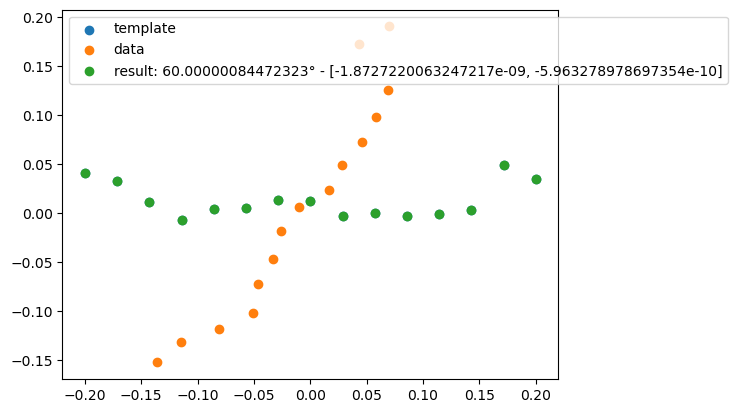

In [162]:
d = {'x': np.linspace(-0.2,0.2,15), 'y': (np.linspace(-0.2,0.2,15))**2+np.random.normal(0, 0.001,15)}
stand = pd.DataFrame(data=d)
template2=stand.T.to_numpy()
data2=transformation(np.pi/3,1,2,template2)

T, error = icp(data2,template2)
dx = T[0,2]
dy = T[1,2]
rotation = np.arcsin(T[0,1]) * 360 / 2 / np.pi

print("T",T)
print("error",error)
print("rotation°",rotation)
print("dx",dx)
print("dy",dy)

result = cv.transform(np.array([data2.T], copy=True).astype(np.float32), T).T
plt.scatter(template2[0], template2[1], label="template")
plt.scatter(data2[0], data2[1], label="data")
plt.scatter(result[0], result[1], label="result: "+str(rotation)+"° - "+str([dx,dy]))
plt.legend(loc="upper left")
plt.show()

src (1, 8, 2)
Tr[0:2] (2, 3)
T [[ 0.07389496  0.99726603 -1.67358942]
 [-0.99726603  0.07389496  2.07965267]
 [ 0.          0.          1.        ]]
error 0.03377158974707468
rotation° 85.76226788910022
dx -1.6735894223893735
dy 2.0796526729572467


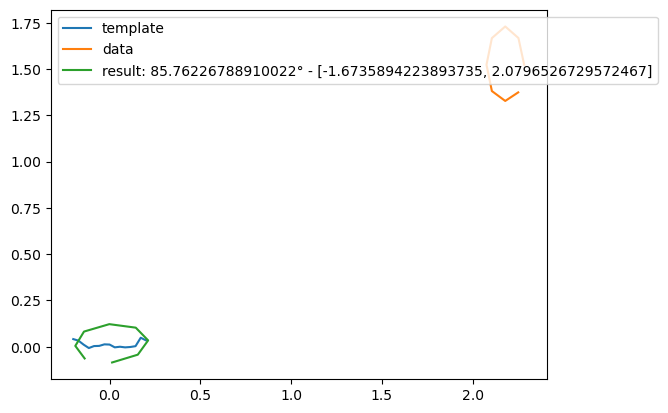

In [164]:
T, error = icp(data1,template2)
dx = T[0,2]
dy = T[1,2]
rotation = np.arcsin(T[0,1]) * 360 / 2 / np.pi

print("T",T)
print("error",error)
print("rotation°",rotation)
print("dx",dx)
print("dy",dy)

result = cv.transform(np.array([data1.T], copy=True).astype(np.float32), T).T
plt.plot(template2[0], template2[1], label="template")
plt.plot(data1[0], data1[1], label="data")
plt.plot(result[0], result[1], label="result: "+str(rotation)+"° - "+str([dx,dy]))
plt.legend(loc="upper left")
plt.show()

src (1, 15, 2)
Tr[0:2] (2, 3)
T [[ 9.99233963e-01  3.91342153e-02  6.93314432e-03]
 [-3.91342153e-02  9.99233963e-01 -7.66754579e-04]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
error 0.06186353591305305
rotation° 2.2427980882706278
dx 0.006933144324727965
dy -0.0007667545790407345


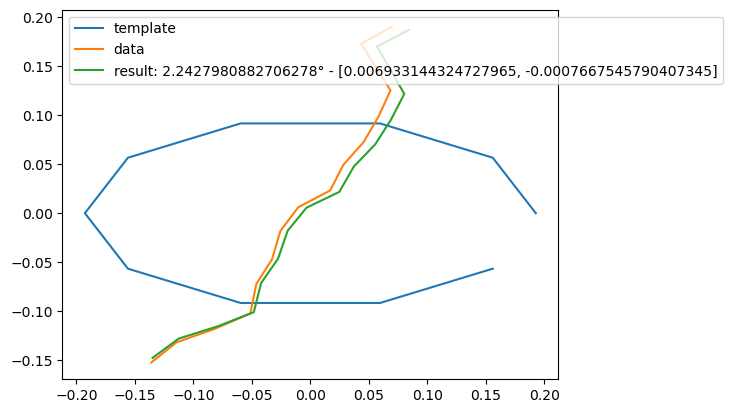

In [165]:
T, error = icp(data2,template1)
dx = T[0,2]
dy = T[1,2]
rotation = np.arcsin(T[0,1]) * 360 / 2 / np.pi

print("T",T)
print("error",error)
print("rotation°",rotation)
print("dx",dx)
print("dy",dy)

result = cv.transform(np.array([data2.T], copy=True).astype(np.float32), T).T
plt.plot(template1[0], template1[1], label="template")
plt.plot(data2[0], data2[1], label="data")
plt.plot(result[0], result[1], label="result: "+str(rotation)+"° - "+str([dx,dy]))
plt.legend(loc="upper left")
plt.show()